In [1]:
import os, sys, copy
import math
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from statistics import mode

sns.set_theme()
%matplotlib inline

# To export to PDF, run:
# jupyter nbconvert --to webpdf --allow-chromium-download assignment_02.ipynb

In [2]:
datadir = '../Datasets/'

## define edges color
cls_edges = 'gainsboro'

## we will consider 3 types of nodes with the following colors and sizes:
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [3]:
cm_names = ['degree', 'pagerank', 'authority', 'hub', 'between', 'closeness']

## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in', weights=weights),\
              g.strength(mode='out', weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

def generate_centrality_measure(G, node_type_name, with_weight=True):
    if with_weight:
        ## compute normalized weights 
        mw = np.max(G.es['weight'])
        G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]
        normalized_weight = 'normalized_weight'
        weights = 'weight'
    else:
        normalized_weight = None
        weights = None
    
    ## compute several centrality measures for the CA subgraph G
    C = pd.DataFrame({node_type_name: G.vs()['name'],
                      'd': G.degree(),
                      'degree': degree_centrality(G,weights=normalized_weight),
                      'pagerank': G.pagerank(weights=weights),
                      'authority': G.authority_score(weights=weights),
                      'hub': G.hub_score(weights=weights),
                      'between': G.betweenness(),
                      'closeness': G.closeness()})

    ## normalize betweenness
    n = G.vcount()
    C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
    
    return C

# Problem 1

In [4]:
## read edges and build weighted directed graph
D = pd.read_csv(os.path.join(datadir, 'Airports/connections.csv'))
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
print('State:', A.state.unique())
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

State: ['PA' 'TX' 'NM' 'SD' 'GA' 'CA' 'NJ' 'AK' 'LA' 'IN' 'NY' 'IA' 'WA' 'AL'
 'SC' 'FL' 'MI' 'OR' 'WI' 'ME' 'NC' 'AZ' 'CT' 'NE' 'MT' 'ND' 'MN' 'OH'
 'WV' 'IL' 'TN' 'MA' 'VT' 'KY' 'MD' 'UT' 'MO' 'VA' 'CO' 'WY' 'DC' 'KS'
 'DE' 'NV' 'AR' 'MS' 'HI' 'ID' 'OK' 'NH' 'RI']
464 nodes and 12000 directed edges


In [5]:
display(D.head())
display(A.head())

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [6]:
## Build smaller subgraph 'G' for New York
G = g.subgraph([v for v in g.vs() if v['state'] == 'NY'])

## drop isolated vertices (i.e. without in-state connections)
G = G.subgraph([v for v in G.vs() if v.degree()>0])

## remove loops if any
G = G.simplify(multiple=False)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')

13 nodes and 50 directed edges


In [7]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

def generate_centrality_measure(G, node_type_name, with_weight=True):
    if with_weight:
        ## compute normalized weights 
        mw = np.max(G.es['weight'])
        G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]
        normalized_weight = 'normalized_weight'
        weights = 'weight'
    else:
        normalized_weight = None
        weights = None
    
    ## compute several centrality measures for the CA subgraph G
    C = pd.DataFrame({node_type_name: G.vs()['name'],
                      'd': G.degree(),
                      'degree': degree_centrality(G,weights=normalized_weight),
                      'pagerank': G.pagerank(weights=weights),
                      'authority': G.authority_score(weights=weights),
                      'hub': G.hub_score(weights=weights),
                      'between': G.betweenness(),
                      'closeness': G.closeness()})

    ## normalize betweenness
    n = G.vcount()
    C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
    
    return C

In [8]:
C = generate_centrality_measure(G, node_type_name='airport')

## sort w.r.t. degree centrality, look at top airports
Cs = C.sort_values(by='degree', ascending=False)
Cs.head()

,airport,d,degree,pagerank,authority,hub,between,closeness
0,JFK,14,0.173125,0.342720,1.000000,0.373760,0.647727,0.705882
2,BUF,12,0.101629,0.195702,0.261299,1.000000,0.167929,0.705882
4,ROC,9,0.054908,0.109433,0.141841,0.546989,0.000000,0.631579
5,SYR,14,0.044959,0.097118,0.113975,0.459400,0.243687,0.750000
1,LGA,14,0.040011,0.108312,0.213367,0.078989,0.286616,0.750000


# Problem 2

In [9]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [10]:
## power law graph
gamma = 2.5
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl)

## number of isolated nodes (no edges)
iso = n - g1.vcount()
print('isolates:',iso)

isolates: 1872


In [11]:
C = generate_centrality_measure(g1, node_type_name='node_id', with_weight=False)
C.head()

,node_id,d,degree,pagerank,authority,hub,between,closeness
0,94,14,0.001723,0.000424,0.014150,0.014150,0.002622,0.207897
1,4219,1,0.000123,0.000044,0.001080,0.001080,0.000000,0.172119
2,123,21,0.002584,0.000605,0.105427,0.105427,0.007892,0.238184
3,3904,1,0.000123,0.000043,0.008045,0.008045,0.000000,0.192371
4,3951,3,0.000369,0.000138,0.000448,0.000448,0.000259,0.161217


In [12]:
degrees = g1.degree()
min_degree = min(degrees)
max_degree = max(degrees)
ls_mean_centrality_measure = []
print(f'min_degree={min_degree} - max_degree={max_degree}')
for k in sorted(set(degrees)):
#     G1 = g1.subgraph([v for v in g1.vs() if v.degree() == k])
#     if len(G1.vs()) <= 0: continue
#     G1_vs_ids = [v['name'] for v in G1.vs()]
#     C1 = C[C['node_id'].isin(G1_vs_ids)]
    C1 = C[C['d']==k]
    mean_df = C1[cm_names].mean(axis=0)
    ls_mean_centrality_measure.append([k] + list(mean_df.values))

min_degree=1 - max_degree=103


In [13]:
df2 = pd.DataFrame(np.array(ls_mean_centrality_measure),
                   columns=['k'] + cm_names).fillna(0.0)
display(df2.head())

,k,degree,pagerank,authority,hub,between,closeness
0,1.0,0.000123,0.000059,0.003427,0.003427,0.000000,0.260585
1,2.0,0.000246,0.000085,0.006757,0.006757,0.000122,0.188432
2,3.0,0.000369,0.000112,0.011180,0.011180,0.000272,0.188496
3,4.0,0.000492,0.000141,0.012963,0.012963,0.000416,0.193171
4,5.0,0.000615,0.000168,0.018655,0.018655,0.000614,0.199173


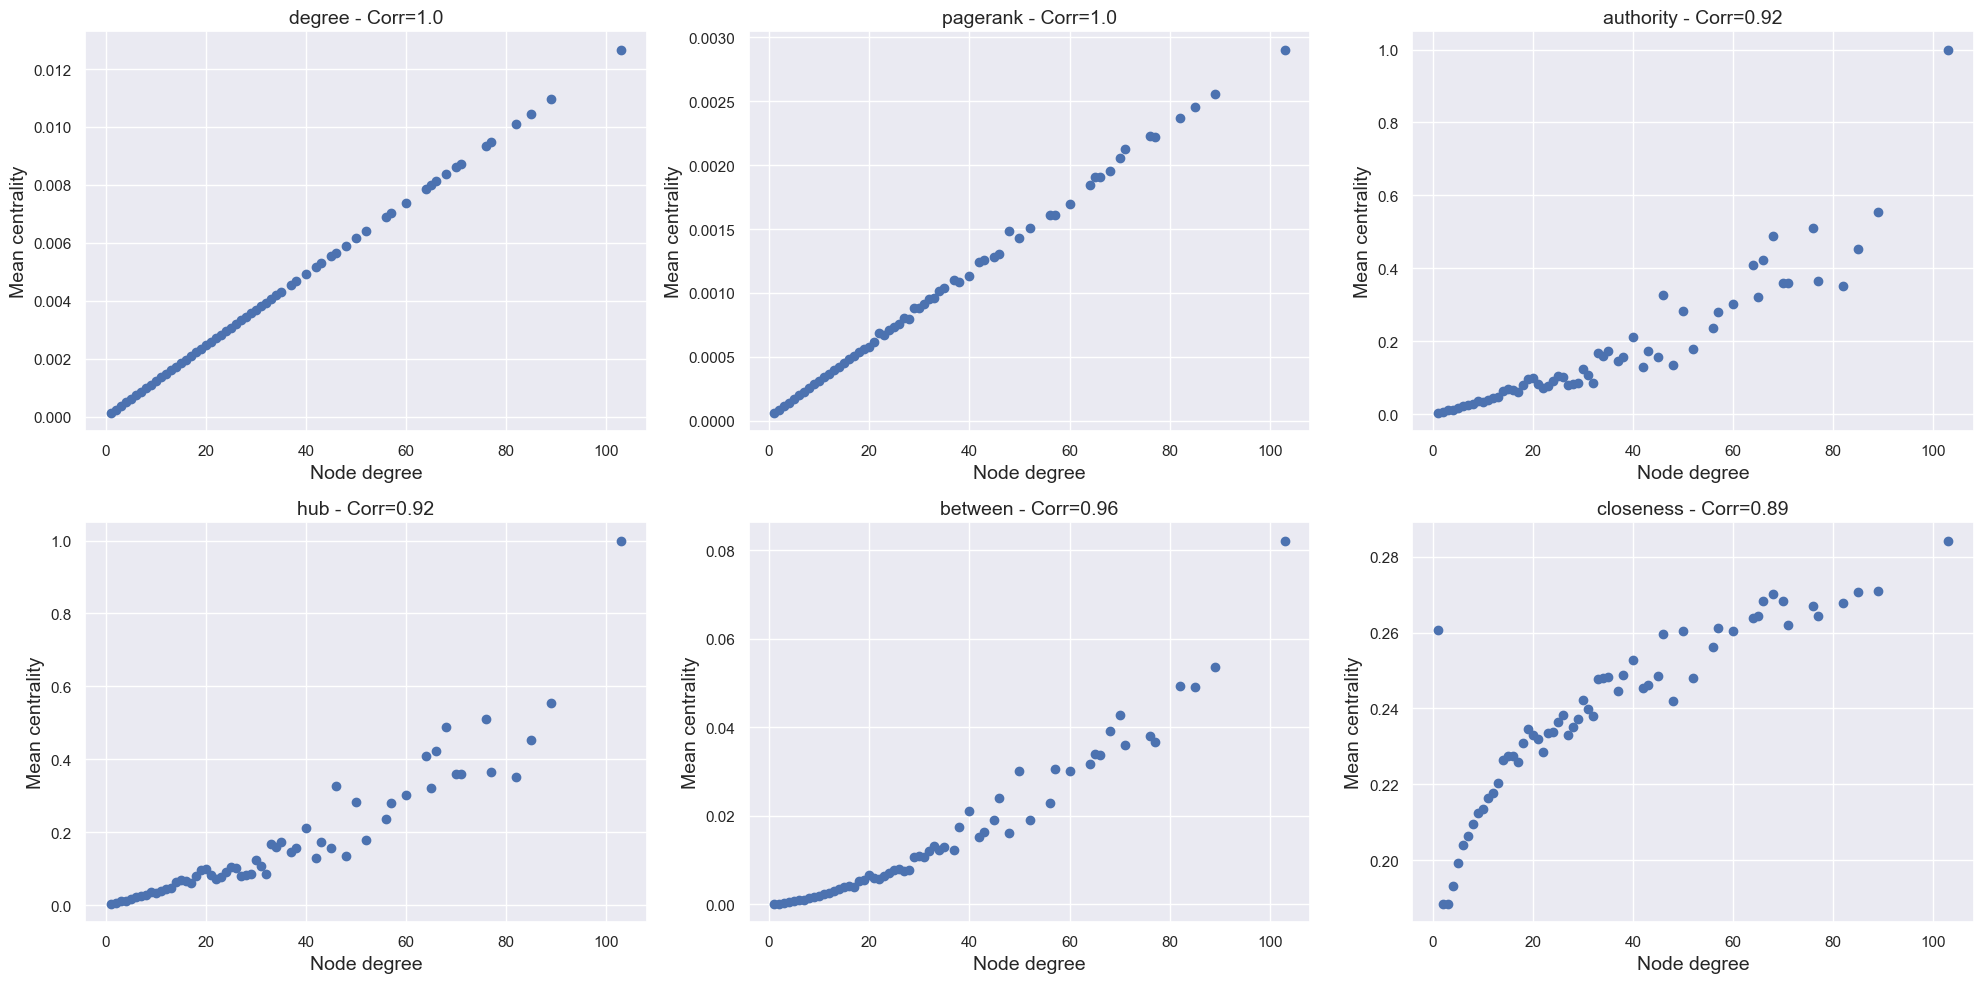

In [14]:
ncols = 3
nrows = math.ceil(len(cm_names)/ncols)
fig, axes = plt.subplots(figsize=[20, 5*nrows], nrows=nrows, ncols=ncols)
xticks = range(min_degree, max_degree+1)

for i,var in enumerate(cm_names):
    corr = np.round(df2['k'].corr(df2[var]), 2)
    ax = axes[i//ncols, i%ncols]
    ax.scatter(x=df2['k'], y=df2[var])
    ax.grid(True)
    ax.set_title(f'{var} - Corr={corr}', size=14)
    ax.set_xlabel('Node degree', size=14)
    ax.set_ylabel('Mean centrality', size=14)

# fig.suptitle(, size=14)
plt.tight_layout()
plt.show()

# Problem 3

In [15]:
## read edges and build weighted directed graph
D = pd.read_csv(os.path.join(datadir, 'Airports/connections.csv'))
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
A.state.unique()

array(['PA', 'TX', 'NM', 'SD', 'GA', 'CA', 'NJ', 'AK', 'LA', 'IN', 'NY',
       'IA', 'WA', 'AL', 'SC', 'FL', 'MI', 'OR', 'WI', 'ME', 'NC', 'AZ',
       'CT', 'NE', 'MT', 'ND', 'MN', 'OH', 'WV', 'IL', 'TN', 'MA', 'VT',
       'KY', 'MD', 'UT', 'MO', 'VA', 'CO', 'WY', 'DC', 'KS', 'DE', 'NV',
       'AR', 'MS', 'HI', 'ID', 'OK', 'NH', 'RI'], dtype=object)

In [16]:
# get big weakly connected component
G = g.connected_components(mode='weak').giant()

In [17]:
# get centrality with weights
C = generate_centrality_measure(G, node_type_name='airport')
for cm_name in cm_names:
    print(f"\n\n=========== centrality_measure = {cm_name} ===========")
    for ascending in [True, False]:
        print(f"----------- remove_smallest = {ascending} ----------")
        G_i = copy.deepcopy(G)
        C = C.sort_values(by=cm_name, ascending=ascending)
        ls_airport_i = C['airport'].values.tolist()
        removed_airports = []
        while G_i.is_connected(mode='weak'):
            if (len(G_i.vs()) == 0) or (len(G_i.es()) == 0):
                break
            removed_one = ls_airport_i.pop()
            removed_airports.append(removed_one)
            vs = G_i.vs()
            G_i.delete_vertices([removed_one])
        print(f"remove {len(removed_airports)} airports")



=========== centrality_measure = degree ===========
----------- remove_smallest = True ----------
remove 2 airports
----------- remove_smallest = False ----------
remove 179 airports


=========== centrality_measure = pagerank ===========
----------- remove_smallest = True ----------
remove 2 airports
----------- remove_smallest = False ----------
remove 36 airports


=========== centrality_measure = authority ===========
----------- remove_smallest = True ----------
remove 2 airports
----------- remove_smallest = False ----------
remove 10 airports


=========== centrality_measure = hub ===========
----------- remove_smallest = True ----------
remove 2 airports
----------- remove_smallest = False ----------
remove 462 airports


=========== centrality_measure = between ===========
----------- remove_smallest = True ----------
remove 4 airports
----------- remove_smallest = False ----------
remove 462 airports


=========== centrality_measure = closeness ===========
----------- remov

In [18]:
# get centrality without weights
C = generate_centrality_measure(G, node_type_name='airport', with_weight=False)
for cm_name in cm_names:
    print(f"\n\n=========== centrality_measure = {cm_name} ===========")
    for ascending in [True, False]:
        print(f"----------- remove_smallest = {ascending} ----------")
        G_i = copy.deepcopy(G)
        C = C.sort_values(by=cm_name, ascending=ascending)
        ls_airport_i = C['airport'].values.tolist()
        removed_airports = []
        while G_i.is_connected(mode='weak'):
            if (len(G_i.vs()) == 0) or (len(G_i.es()) == 0):
                break
            removed_one = ls_airport_i.pop()
            removed_airports.append(removed_one)
            vs = G_i.vs()
            G_i.delete_vertices([removed_one])
        print(f"remove {len(removed_airports)} airports")



=========== centrality_measure = degree ===========
----------- remove_smallest = True ----------
remove 3 airports
----------- remove_smallest = False ----------
remove 462 airports


=========== centrality_measure = pagerank ===========
----------- remove_smallest = True ----------
remove 6 airports
----------- remove_smallest = False ----------
remove 189 airports


=========== centrality_measure = authority ===========
----------- remove_smallest = True ----------
remove 2 airports
----------- remove_smallest = False ----------
remove 10 airports


=========== centrality_measure = hub ===========
----------- remove_smallest = True ----------
remove 2 airports
----------- remove_smallest = False ----------
remove 20 airports


=========== centrality_measure = between ===========
----------- remove_smallest = True ----------
remove 4 airports
----------- remove_smallest = False ----------
remove 462 airports


=========== centrality_measure = closeness ===========
----------- remov

**Observation:** The results when centrality measures computed with weights and without weights are slightly different. However, in overall, we need to remove more nodes with low centrality value to make the graph disconnected compared to remove nodes with high centrality value.

# Problem 5

In [19]:
## read edges and build weighted directed graph
D = pd.read_csv(os.path.join(datadir, 'Airports/connections.csv'))
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['state'] = [A['state'][i] for i in l]

In [20]:
states = sorted(set([v['state'] for v in g.vs()]))
state_dict = {state:i for i, state in enumerate(states)}
mapping = [state_dict[v['state']] for v in g.vs()]
state_g = g.copy()
state_g.contract_vertices(mapping, combine_attrs='first')
state_g = state_g.simplify(loops=True, combine_edges={"weight": sum})

In [21]:
print('Number of original nodes:', len(g.vs()))
print('Number of state:', len(states))
print('Number of nodes in state-to-state graph:', len(state_g.vs()))

Number of original nodes: 464
Number of state: 51
Number of nodes in state-to-state graph: 51


## Problem 5a

In [22]:
print(state_g.vcount())
state_g_biggest_strong_comp = state_g.connected_components(mode='STRONG').giant()
print(state_g_biggest_strong_comp.vcount())
state_g_biggest_weak_comp = state_g.connected_components(mode='WEAK').giant()
print(state_g_biggest_weak_comp.vcount())
# ---> Strong connected

51
51
51


## Problem 5b

In [23]:
out_degree = state_g.strength(mode='out', weights='weight')
in_degree = state_g.strength(mode='in', weights='weight')
df = pd.DataFrame({'state': state_g.vs['state'], 'in_degree': in_degree, 'out_degree': out_degree})
max_in_degree = df['in_degree'].max()
max_out_degree = df['out_degree'].max()
print('State has the most incoming passengers:', df[df['in_degree']==max_in_degree]['state'].values)
print('State has the most departing passengers:', df[df['out_degree']==max_out_degree]['state'].values)

State has the most incoming passengers: ['CA']
State has the most departing passengers: ['CA']


In [24]:
# state_vs = state_g.vs()
# for v in state_vs:
#     print("-----------------")
#     out_es = state_g.es.select(_source=v)
#     out_weight = sum(out_e['weight'] for out_e in out_es)
#     print(f"passengers depart {v['state']}: {out_weight}")
    
#     in_es = state_g.es.select(_target=v)
#     in_weight = sum(in_e['weight'] for in_e in in_es)
#     print(f"passengers arrive {v['state']}: {in_weight}")

## Problem 5c

In [25]:
state_vs = state_g.vs
state_es = list(state_g.es())
state_es.sort(key=lambda x: x['weight'], reverse=True)
busiest_route = state_es[0]
source_vertex_id = busiest_route.source
target_vertex_id = busiest_route.target
source_vertex = state_vs[source_vertex_id]
target_vertex = state_vs[target_vertex_id]

print('Pair of airports have the most passengers travelling from x to y')
print('x:', source_vertex['state'], '- y:', target_vertex['state'], '- num_passengers:', busiest_route['weight'])

Pair of airports have the most passengers travelling from x to y
x: FL - y: GA - num_passengers: 6584065


## Problem 5d

In [26]:
state_g.vs['name'] = state_g.vs['state']
state_C = generate_centrality_measure(state_g, node_type_name='state')[['state']+cm_names]

for cm in ['degree', 'between']:
    print(f"\nTop {cm} centrality")
    state_Cs = state_C.sort_values(by=cm, ascending=False)
    display(state_Cs.head())


Top degree centrality


,state,degree,pagerank,authority,hub,between,closeness
4,CA,0.135169,0.075945,0.969771,0.971337,0.021798,0.943396
9,FL,0.131269,0.073844,1.000000,1.000000,0.025327,0.943396
43,TX,0.130073,0.077688,0.925013,0.925349,0.028044,0.980392
10,GA,0.107684,0.064350,0.829178,0.827263,0.024180,0.961538
14,IL,0.104197,0.063423,0.743696,0.742924,0.037366,1.000000



Top between centrality


,state,degree,pagerank,authority,hub,between,closeness
14,IL,0.104197,0.063423,0.743696,0.742924,0.037366,1.000000
35,OH,0.047638,0.030171,0.362870,0.363212,0.030574,0.980392
43,TX,0.130073,0.077688,0.925013,0.925349,0.028044,0.980392
23,MN,0.042512,0.031069,0.284188,0.284230,0.026444,0.961538
7,DC,0.048661,0.030078,0.418859,0.418278,0.026146,0.980392


In [27]:
print('State has highest degree centrality: CA')
print('State has highest between centrality: IL')

State has highest degree centrality: CA
State has highest between centrality: IL
